#### This notebook will discuss the GANs

In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vishesh1412/celebrity-face-image-dataset")

print("Path to dataset files:", path)

Path to dataset files: /home/blackcat/.cache/kagglehub/datasets/vishesh1412/celebrity-face-image-dataset/versions/1


In [3]:
DATA_DIR = path
image_size = 64
batch_size = 256
states = (0.5,0.5,0.5),(0.5,0.5,0.5)

In [4]:
train_ds =ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*states)
]))


train_dl = DataLoader(train_ds, batch_size, shuffle=True, pin_memory=True)

In [5]:
import torch 
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline 

In [6]:
def denorm(img_tensors):
    return img_tensors * states[1][0] + states[0][0]

In [7]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_xticks([]);ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), 
                        nrow=8).permute(1,2,0))

def show_batch(d1,nmax=64):
    for images, _ in d1:
        show_images(images, nmax)
        break


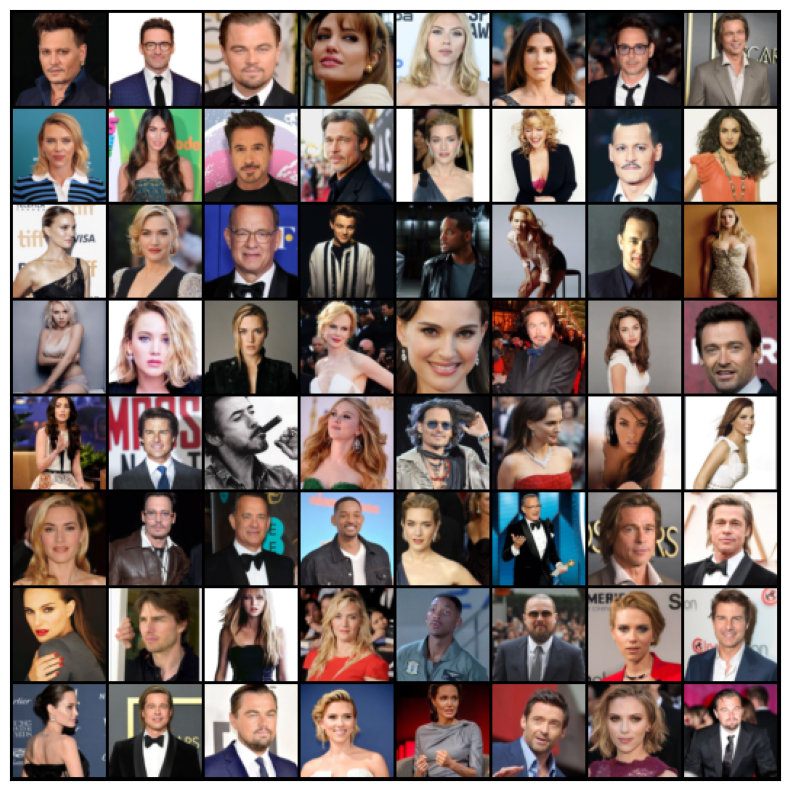

In [8]:
show_batch(train_dl)

In [9]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking = True)

class DeviceDataLoader():
    def __init__(self, d1, device):
        self.d1=d1
        self.device = device
    
    def __iter__(self):
        for b in self.d1:
            yield to_device(b, self.device)

        def __len__(self):
            return len(self.d1)

In [10]:
device = get_default_device()
device

device(type='cpu')

In [11]:
train_dl = DeviceDataLoader(train_dl, device)

In [12]:
import torch.nn as nn

In [13]:
discriminator = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),

    nn.Flatten(),
    nn.Sigmoid()


)

In [14]:
discriminator = to_device(discriminator, device)

In [15]:
latent_size = 128

In [16]:
generator = nn.Sequential(
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()


)

In [17]:
generator = to_device(generator, device)

In [18]:
import torch.nn.functional as F
def train_discriminator(real_images, opt_d):

    opt_d.zero_grad()
    real_preds =discriminator(real_images)
    real_targets = torch.ones(real_images.size(0),1,device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    fake_targets = torch.zeros(fake_images.size(0),1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    loss = real_loss + fake_loss
    loss.backward()
    #opt_d.stop()
    return loss.item(), real_score, fake_score

In [19]:
import torch.nn.functional as F
def train_generator(opt_g):
    opt_g.zero_grad()

    latent = torch.randn(batch_size, latent_size, 1,1, device=device)
    fake_image = generator(latent)

    preds = discriminator(fake_image)
    targets = torch.ones(batch_size,1,device=device)
    loss = F.binary_cross_entropy(preds, targets)

    loss.backward()
    #opt_g.stop()

    return loss.item()

In [20]:
from torchvision.utils import save_image

In [21]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [22]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated_image_{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_xticks([]);ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1,2,0))

In [23]:
fixed_latent = torch.rand(64, latent_size, 1,1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99984866..0.999944].


Saving generated_image_0000.png


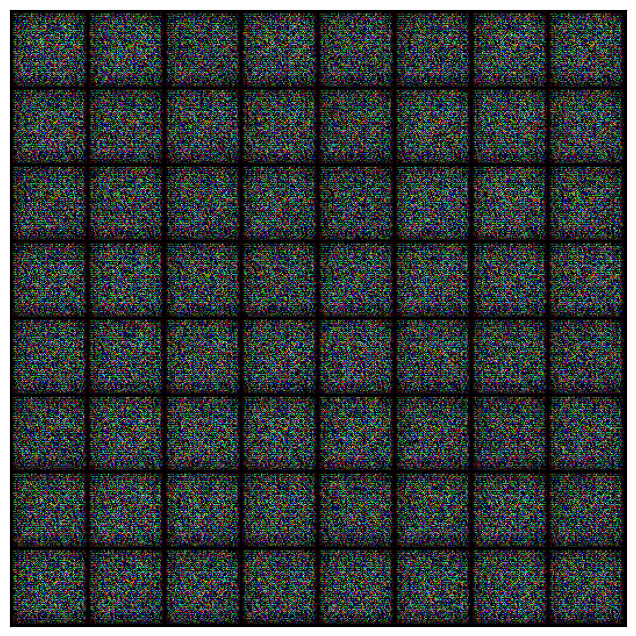

In [24]:
save_samples(0,fixed_latent)

In [25]:
from tqdm import tqdm
import torch.nn.functional as F

In [26]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()


    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))


    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):

            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            loss_g = train_generator(opt_g)

        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)



        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score
        ))

        save_samples(epoch+start_idx, fixed_latent, show=False)
    return losses_g, losses_d, real_scores, fake_scores



In [27]:
!pip3 install IProgress
!pip3 install ipywidgets

In [28]:
%%time
lr = 0.005
epochs = 400 #to get better result need to update this to 500 but will take huge huge time
history = fit(epochs, lr)

8it [00:51,  6.44s/it]


Epoch [1/400], loss_g: 0.5887, loss_d: 1.3926, real_score: 0.5755, fake_score: 0.5552
Saving generated_image_0001.png


8it [00:49,  6.20s/it]


Epoch [2/400], loss_g: 0.6070, loss_d: 1.3946, real_score: 0.5880, fake_score: 0.5647
Saving generated_image_0002.png


8it [00:51,  6.38s/it]


Epoch [3/400], loss_g: 0.5934, loss_d: 1.4092, real_score: 0.5746, fake_score: 0.5598
Saving generated_image_0003.png


8it [00:51,  6.41s/it]


Epoch [4/400], loss_g: 0.5919, loss_d: 1.2977, real_score: 0.6311, fake_score: 0.5578
Saving generated_image_0004.png


8it [00:52,  6.55s/it]


Epoch [5/400], loss_g: 0.5884, loss_d: 1.2786, real_score: 0.6453, fake_score: 0.5574
Saving generated_image_0005.png


8it [00:51,  6.47s/it]


Epoch [6/400], loss_g: 0.5895, loss_d: 1.3566, real_score: 0.5973, fake_score: 0.5556
Saving generated_image_0006.png


8it [00:51,  6.49s/it]


Epoch [7/400], loss_g: 0.5871, loss_d: 1.3888, real_score: 0.5792, fake_score: 0.5577
Saving generated_image_0007.png


8it [00:52,  6.52s/it]


Epoch [8/400], loss_g: 0.5997, loss_d: 1.4181, real_score: 0.5592, fake_score: 0.5538
Saving generated_image_0008.png


8it [00:52,  6.56s/it]


Epoch [9/400], loss_g: 0.5901, loss_d: 1.3596, real_score: 0.5993, fake_score: 0.5608
Saving generated_image_0009.png


8it [00:52,  6.61s/it]


Epoch [10/400], loss_g: 0.5856, loss_d: 1.3803, real_score: 0.5831, fake_score: 0.5526
Saving generated_image_0010.png


8it [00:52,  6.61s/it]


Epoch [11/400], loss_g: 0.5893, loss_d: 1.4675, real_score: 0.5576, fake_score: 0.5737
Saving generated_image_0011.png


8it [00:52,  6.61s/it]


Epoch [12/400], loss_g: 0.5867, loss_d: 1.3168, real_score: 0.6279, fake_score: 0.5632
Saving generated_image_0012.png


8it [00:52,  6.62s/it]


Epoch [13/400], loss_g: 0.5900, loss_d: 1.3220, real_score: 0.6111, fake_score: 0.5528
Saving generated_image_0013.png


8it [00:52,  6.61s/it]


Epoch [14/400], loss_g: 0.5904, loss_d: 1.3946, real_score: 0.5927, fake_score: 0.5651
Saving generated_image_0014.png


8it [00:52,  6.59s/it]


Epoch [15/400], loss_g: 0.5982, loss_d: 1.2868, real_score: 0.6378, fake_score: 0.5548
Saving generated_image_0015.png


8it [00:52,  6.62s/it]


Epoch [16/400], loss_g: 0.5922, loss_d: 1.4085, real_score: 0.5664, fake_score: 0.5563
Saving generated_image_0016.png


8it [00:53,  6.63s/it]


Epoch [17/400], loss_g: 0.5849, loss_d: 1.3365, real_score: 0.6107, fake_score: 0.5586
Saving generated_image_0017.png


8it [00:52,  6.62s/it]


Epoch [18/400], loss_g: 0.5983, loss_d: 1.3971, real_score: 0.5864, fake_score: 0.5665
Saving generated_image_0018.png


8it [01:04,  8.09s/it]


Epoch [19/400], loss_g: 0.5905, loss_d: 1.3726, real_score: 0.5873, fake_score: 0.5574
Saving generated_image_0019.png


8it [00:51,  6.47s/it]


Epoch [20/400], loss_g: 0.5966, loss_d: 1.4419, real_score: 0.5550, fake_score: 0.5634
Saving generated_image_0020.png


8it [00:54,  6.78s/it]


Epoch [21/400], loss_g: 0.5888, loss_d: 1.3775, real_score: 0.5875, fake_score: 0.5580
Saving generated_image_0021.png


8it [00:52,  6.56s/it]


Epoch [22/400], loss_g: 0.5931, loss_d: 1.4647, real_score: 0.5378, fake_score: 0.5592
Saving generated_image_0022.png


8it [00:52,  6.59s/it]


Epoch [23/400], loss_g: 0.5945, loss_d: 1.3595, real_score: 0.5988, fake_score: 0.5599
Saving generated_image_0023.png


8it [00:52,  6.51s/it]


Epoch [24/400], loss_g: 0.6020, loss_d: 1.3716, real_score: 0.5875, fake_score: 0.5547
Saving generated_image_0024.png


8it [00:51,  6.50s/it]


Epoch [25/400], loss_g: 0.5930, loss_d: 1.2743, real_score: 0.6408, fake_score: 0.5534
Saving generated_image_0025.png


8it [00:51,  6.46s/it]


Epoch [26/400], loss_g: 0.6134, loss_d: 1.4315, real_score: 0.5556, fake_score: 0.5592
Saving generated_image_0026.png


8it [00:51,  6.48s/it]


Epoch [27/400], loss_g: 0.5937, loss_d: 1.3293, real_score: 0.6095, fake_score: 0.5527
Saving generated_image_0027.png


8it [00:52,  6.53s/it]


Epoch [28/400], loss_g: 0.5805, loss_d: 1.3657, real_score: 0.5959, fake_score: 0.5606
Saving generated_image_0028.png


8it [00:52,  6.61s/it]


Epoch [29/400], loss_g: 0.6011, loss_d: 1.3830, real_score: 0.5917, fake_score: 0.5656
Saving generated_image_0029.png


8it [00:53,  6.63s/it]


Epoch [30/400], loss_g: 0.5958, loss_d: 1.3823, real_score: 0.5991, fake_score: 0.5627
Saving generated_image_0030.png


8it [00:53,  6.65s/it]


Epoch [31/400], loss_g: 0.5956, loss_d: 1.3857, real_score: 0.5881, fake_score: 0.5608
Saving generated_image_0031.png


8it [00:47,  5.99s/it]


Epoch [32/400], loss_g: 0.5776, loss_d: 1.3003, real_score: 0.6273, fake_score: 0.5560
Saving generated_image_0032.png


8it [00:52,  6.57s/it]


Epoch [33/400], loss_g: 0.5780, loss_d: 1.4296, real_score: 0.5612, fake_score: 0.5595
Saving generated_image_0033.png


8it [00:52,  6.53s/it]


Epoch [34/400], loss_g: 0.6001, loss_d: 1.4475, real_score: 0.5618, fake_score: 0.5644
Saving generated_image_0034.png


8it [00:56,  7.08s/it]


Epoch [35/400], loss_g: 0.5771, loss_d: 1.2999, real_score: 0.6244, fake_score: 0.5532
Saving generated_image_0035.png


8it [01:08,  8.59s/it]


Epoch [36/400], loss_g: 0.5861, loss_d: 1.3829, real_score: 0.5942, fake_score: 0.5603
Saving generated_image_0036.png


8it [00:57,  7.16s/it]


Epoch [37/400], loss_g: 0.5939, loss_d: 1.5608, real_score: 0.4926, fake_score: 0.5606
Saving generated_image_0037.png


8it [00:57,  7.14s/it]


Epoch [38/400], loss_g: 0.5909, loss_d: 1.4195, real_score: 0.5719, fake_score: 0.5649
Saving generated_image_0038.png


8it [00:58,  7.32s/it]


Epoch [39/400], loss_g: 0.6049, loss_d: 1.3295, real_score: 0.6039, fake_score: 0.5492
Saving generated_image_0039.png


8it [00:58,  7.26s/it]


Epoch [40/400], loss_g: 0.5820, loss_d: 1.4757, real_score: 0.5355, fake_score: 0.5590
Saving generated_image_0040.png


8it [00:57,  7.24s/it]


Epoch [41/400], loss_g: 0.5704, loss_d: 1.4082, real_score: 0.5707, fake_score: 0.5614
Saving generated_image_0041.png


8it [00:59,  7.46s/it]


Epoch [42/400], loss_g: 0.5964, loss_d: 1.4053, real_score: 0.5777, fake_score: 0.5638
Saving generated_image_0042.png


8it [00:58,  7.32s/it]


Epoch [43/400], loss_g: 0.6079, loss_d: 1.3752, real_score: 0.5877, fake_score: 0.5560
Saving generated_image_0043.png


8it [00:58,  7.35s/it]


Epoch [44/400], loss_g: 0.5923, loss_d: 1.3279, real_score: 0.6144, fake_score: 0.5550
Saving generated_image_0044.png


8it [00:59,  7.43s/it]


Epoch [45/400], loss_g: 0.5990, loss_d: 1.3723, real_score: 0.5805, fake_score: 0.5523
Saving generated_image_0045.png


8it [00:54,  6.81s/it]


Epoch [46/400], loss_g: 0.5973, loss_d: 1.3974, real_score: 0.5806, fake_score: 0.5635
Saving generated_image_0046.png


8it [01:01,  7.75s/it]


Epoch [47/400], loss_g: 0.6016, loss_d: 1.3103, real_score: 0.6319, fake_score: 0.5596
Saving generated_image_0047.png


8it [01:00,  7.51s/it]


Epoch [48/400], loss_g: 0.6046, loss_d: 1.4150, real_score: 0.5672, fake_score: 0.5618
Saving generated_image_0048.png


8it [01:00,  7.55s/it]


Epoch [49/400], loss_g: 0.5865, loss_d: 1.3476, real_score: 0.6165, fake_score: 0.5653
Saving generated_image_0049.png


8it [01:00,  7.62s/it]


Epoch [50/400], loss_g: 0.5849, loss_d: 1.5115, real_score: 0.5288, fake_score: 0.5683
Saving generated_image_0050.png


8it [01:01,  7.68s/it]


Epoch [51/400], loss_g: 0.6055, loss_d: 1.3600, real_score: 0.6005, fake_score: 0.5582
Saving generated_image_0051.png


8it [01:02,  7.79s/it]


Epoch [52/400], loss_g: 0.5817, loss_d: 1.3933, real_score: 0.5817, fake_score: 0.5585
Saving generated_image_0052.png


8it [01:00,  7.61s/it]


Epoch [53/400], loss_g: 0.6044, loss_d: 1.3236, real_score: 0.6064, fake_score: 0.5494
Saving generated_image_0053.png


8it [00:59,  7.49s/it]


Epoch [54/400], loss_g: 0.5919, loss_d: 1.3714, real_score: 0.5864, fake_score: 0.5562
Saving generated_image_0054.png


8it [01:00,  7.53s/it]


Epoch [55/400], loss_g: 0.6130, loss_d: 1.4098, real_score: 0.5624, fake_score: 0.5564
Saving generated_image_0055.png


8it [01:00,  7.51s/it]


Epoch [56/400], loss_g: 0.5999, loss_d: 1.4573, real_score: 0.5556, fake_score: 0.5637
Saving generated_image_0056.png


8it [01:00,  7.58s/it]


Epoch [57/400], loss_g: 0.5922, loss_d: 1.3630, real_score: 0.5892, fake_score: 0.5522
Saving generated_image_0057.png


8it [01:01,  7.63s/it]


Epoch [58/400], loss_g: 0.5976, loss_d: 1.3972, real_score: 0.5788, fake_score: 0.5596
Saving generated_image_0058.png


8it [01:01,  7.66s/it]


Epoch [59/400], loss_g: 0.5880, loss_d: 1.3883, real_score: 0.5811, fake_score: 0.5623
Saving generated_image_0059.png


8it [01:01,  7.67s/it]


Epoch [60/400], loss_g: 0.5817, loss_d: 1.4221, real_score: 0.5572, fake_score: 0.5567
Saving generated_image_0060.png


8it [01:00,  7.52s/it]


Epoch [61/400], loss_g: 0.6008, loss_d: 1.3903, real_score: 0.5739, fake_score: 0.5548
Saving generated_image_0061.png


8it [01:01,  7.70s/it]


Epoch [62/400], loss_g: 0.5866, loss_d: 1.4847, real_score: 0.5325, fake_score: 0.5616
Saving generated_image_0062.png


8it [01:00,  7.59s/it]


Epoch [63/400], loss_g: 0.6044, loss_d: 1.4129, real_score: 0.5751, fake_score: 0.5642
Saving generated_image_0063.png


8it [01:01,  7.64s/it]


Epoch [64/400], loss_g: 0.5958, loss_d: 1.3485, real_score: 0.6221, fake_score: 0.5681
Saving generated_image_0064.png


8it [01:00,  7.57s/it]


Epoch [65/400], loss_g: 0.5997, loss_d: 1.4227, real_score: 0.5660, fake_score: 0.5593
Saving generated_image_0065.png


8it [01:00,  7.60s/it]


Epoch [66/400], loss_g: 0.5958, loss_d: 1.4703, real_score: 0.5368, fake_score: 0.5609
Saving generated_image_0066.png


8it [01:01,  7.66s/it]


Epoch [67/400], loss_g: 0.5842, loss_d: 1.3343, real_score: 0.6231, fake_score: 0.5666
Saving generated_image_0067.png


8it [01:00,  7.62s/it]


Epoch [68/400], loss_g: 0.5842, loss_d: 1.3899, real_score: 0.5681, fake_score: 0.5516
Saving generated_image_0068.png


8it [01:02,  7.78s/it]


Epoch [69/400], loss_g: 0.5911, loss_d: 1.3518, real_score: 0.5999, fake_score: 0.5556
Saving generated_image_0069.png


8it [00:59,  7.43s/it]


Epoch [70/400], loss_g: 0.5917, loss_d: 1.3518, real_score: 0.5961, fake_score: 0.5514
Saving generated_image_0070.png


8it [01:02,  7.76s/it]


Epoch [71/400], loss_g: 0.5921, loss_d: 1.4063, real_score: 0.5896, fake_score: 0.5699
Saving generated_image_0071.png


8it [01:00,  7.51s/it]


Epoch [72/400], loss_g: 0.5907, loss_d: 1.3446, real_score: 0.6037, fake_score: 0.5575
Saving generated_image_0072.png


8it [00:48,  6.04s/it]


Epoch [73/400], loss_g: 0.5837, loss_d: 1.2943, real_score: 0.6389, fake_score: 0.5583
Saving generated_image_0073.png


8it [00:48,  6.10s/it]


Epoch [74/400], loss_g: 0.5944, loss_d: 1.3630, real_score: 0.6018, fake_score: 0.5638
Saving generated_image_0074.png


8it [00:47,  5.95s/it]


Epoch [75/400], loss_g: 0.5989, loss_d: 1.4381, real_score: 0.5647, fake_score: 0.5627
Saving generated_image_0075.png


8it [00:55,  6.96s/it]


Epoch [76/400], loss_g: 0.6052, loss_d: 1.3564, real_score: 0.5964, fake_score: 0.5563
Saving generated_image_0076.png


8it [00:57,  7.15s/it]


Epoch [77/400], loss_g: 0.5899, loss_d: 1.4143, real_score: 0.5620, fake_score: 0.5566
Saving generated_image_0077.png


8it [00:57,  7.14s/it]


Epoch [78/400], loss_g: 0.5907, loss_d: 1.3944, real_score: 0.5746, fake_score: 0.5551
Saving generated_image_0078.png


8it [00:57,  7.15s/it]


Epoch [79/400], loss_g: 0.5935, loss_d: 1.3612, real_score: 0.6029, fake_score: 0.5657
Saving generated_image_0079.png


8it [00:57,  7.16s/it]


Epoch [80/400], loss_g: 0.5833, loss_d: 1.3508, real_score: 0.6096, fake_score: 0.5640
Saving generated_image_0080.png


8it [01:00,  7.60s/it]


Epoch [81/400], loss_g: 0.5958, loss_d: 1.4165, real_score: 0.5737, fake_score: 0.5601
Saving generated_image_0081.png


8it [00:59,  7.46s/it]


Epoch [82/400], loss_g: 0.5937, loss_d: 1.4773, real_score: 0.5315, fake_score: 0.5580
Saving generated_image_0082.png


8it [00:55,  6.99s/it]


Epoch [83/400], loss_g: 0.5845, loss_d: 1.4235, real_score: 0.5651, fake_score: 0.5578
Saving generated_image_0083.png


8it [00:49,  6.17s/it]


Epoch [84/400], loss_g: 0.5902, loss_d: 1.4797, real_score: 0.5377, fake_score: 0.5638
Saving generated_image_0084.png


8it [00:47,  5.99s/it]


Epoch [85/400], loss_g: 0.5999, loss_d: 1.3849, real_score: 0.5912, fake_score: 0.5646
Saving generated_image_0085.png


8it [00:47,  5.97s/it]


Epoch [86/400], loss_g: 0.5892, loss_d: 1.4197, real_score: 0.5476, fake_score: 0.5469
Saving generated_image_0086.png


8it [00:51,  6.45s/it]


Epoch [87/400], loss_g: 0.5906, loss_d: 1.4067, real_score: 0.5754, fake_score: 0.5613
Saving generated_image_0087.png


8it [00:50,  6.26s/it]


Epoch [88/400], loss_g: 0.6031, loss_d: 1.4539, real_score: 0.5401, fake_score: 0.5580
Saving generated_image_0088.png


8it [00:51,  6.43s/it]


Epoch [89/400], loss_g: 0.5814, loss_d: 1.3284, real_score: 0.6202, fake_score: 0.5627
Saving generated_image_0089.png


8it [00:57,  7.23s/it]


Epoch [90/400], loss_g: 0.6131, loss_d: 1.4028, real_score: 0.5675, fake_score: 0.5545
Saving generated_image_0090.png


8it [01:03,  7.90s/it]


Epoch [91/400], loss_g: 0.5810, loss_d: 1.3870, real_score: 0.5883, fake_score: 0.5650
Saving generated_image_0091.png


8it [00:51,  6.39s/it]


Epoch [92/400], loss_g: 0.5946, loss_d: 1.4083, real_score: 0.5637, fake_score: 0.5556
Saving generated_image_0092.png


8it [00:48,  6.02s/it]


Epoch [93/400], loss_g: 0.5931, loss_d: 1.3500, real_score: 0.6064, fake_score: 0.5622
Saving generated_image_0093.png


8it [00:48,  6.01s/it]


Epoch [94/400], loss_g: 0.5892, loss_d: 1.3698, real_score: 0.5979, fake_score: 0.5603
Saving generated_image_0094.png


8it [00:48,  6.04s/it]


Epoch [95/400], loss_g: 0.5963, loss_d: 1.3530, real_score: 0.6080, fake_score: 0.5638
Saving generated_image_0095.png


8it [00:48,  6.04s/it]


Epoch [96/400], loss_g: 0.5918, loss_d: 1.3381, real_score: 0.6041, fake_score: 0.5525
Saving generated_image_0096.png


8it [00:49,  6.16s/it]


Epoch [97/400], loss_g: 0.6029, loss_d: 1.4948, real_score: 0.5379, fake_score: 0.5704
Saving generated_image_0097.png


8it [00:49,  6.20s/it]


Epoch [98/400], loss_g: 0.5850, loss_d: 1.3318, real_score: 0.6168, fake_score: 0.5623
Saving generated_image_0098.png


8it [00:49,  6.13s/it]


Epoch [99/400], loss_g: 0.5953, loss_d: 1.4049, real_score: 0.5805, fake_score: 0.5656
Saving generated_image_0099.png


8it [00:49,  6.17s/it]


Epoch [100/400], loss_g: 0.5991, loss_d: 1.3621, real_score: 0.5932, fake_score: 0.5545
Saving generated_image_0100.png


8it [00:49,  6.20s/it]


Epoch [101/400], loss_g: 0.5927, loss_d: 1.4581, real_score: 0.5364, fake_score: 0.5495
Saving generated_image_0101.png


8it [00:49,  6.22s/it]


Epoch [102/400], loss_g: 0.5944, loss_d: 1.3006, real_score: 0.6346, fake_score: 0.5580
Saving generated_image_0102.png


8it [00:49,  6.16s/it]


Epoch [103/400], loss_g: 0.5845, loss_d: 1.4171, real_score: 0.5612, fake_score: 0.5572
Saving generated_image_0103.png


8it [00:49,  6.16s/it]


Epoch [104/400], loss_g: 0.5994, loss_d: 1.4207, real_score: 0.5704, fake_score: 0.5607
Saving generated_image_0104.png


8it [01:02,  7.87s/it]


Epoch [105/400], loss_g: 0.6112, loss_d: 1.4200, real_score: 0.5722, fake_score: 0.5613
Saving generated_image_0105.png


8it [01:02,  7.78s/it]


Epoch [106/400], loss_g: 0.5929, loss_d: 1.4065, real_score: 0.5592, fake_score: 0.5501
Saving generated_image_0106.png


8it [01:01,  7.74s/it]


Epoch [107/400], loss_g: 0.5961, loss_d: 1.3108, real_score: 0.6275, fake_score: 0.5600
Saving generated_image_0107.png


8it [01:01,  7.71s/it]


Epoch [108/400], loss_g: 0.5905, loss_d: 1.3805, real_score: 0.5882, fake_score: 0.5619
Saving generated_image_0108.png


8it [01:04,  8.09s/it]


Epoch [109/400], loss_g: 0.5958, loss_d: 1.4042, real_score: 0.5780, fake_score: 0.5617
Saving generated_image_0109.png


8it [01:02,  7.81s/it]


Epoch [110/400], loss_g: 0.5890, loss_d: 1.3836, real_score: 0.5925, fake_score: 0.5597
Saving generated_image_0110.png


8it [01:00,  7.62s/it]


Epoch [111/400], loss_g: 0.6088, loss_d: 1.3679, real_score: 0.5852, fake_score: 0.5547
Saving generated_image_0111.png


8it [01:00,  7.51s/it]


Epoch [112/400], loss_g: 0.5975, loss_d: 1.3218, real_score: 0.6234, fake_score: 0.5613
Saving generated_image_0112.png


8it [00:59,  7.42s/it]


Epoch [113/400], loss_g: 0.5988, loss_d: 1.3765, real_score: 0.5767, fake_score: 0.5529
Saving generated_image_0113.png


8it [01:01,  7.70s/it]


Epoch [114/400], loss_g: 0.5850, loss_d: 1.3636, real_score: 0.6091, fake_score: 0.5680
Saving generated_image_0114.png


8it [01:00,  7.57s/it]


Epoch [115/400], loss_g: 0.5941, loss_d: 1.3432, real_score: 0.6139, fake_score: 0.5646
Saving generated_image_0115.png


8it [01:00,  7.62s/it]


Epoch [116/400], loss_g: 0.5926, loss_d: 1.3561, real_score: 0.5885, fake_score: 0.5503
Saving generated_image_0116.png


8it [01:02,  7.76s/it]


Epoch [117/400], loss_g: 0.6067, loss_d: 1.3884, real_score: 0.5892, fake_score: 0.5657
Saving generated_image_0117.png


8it [01:00,  7.62s/it]


Epoch [118/400], loss_g: 0.6002, loss_d: 1.3909, real_score: 0.5899, fake_score: 0.5634
Saving generated_image_0118.png


8it [01:01,  7.67s/it]


Epoch [119/400], loss_g: 0.5924, loss_d: 1.4163, real_score: 0.5697, fake_score: 0.5626
Saving generated_image_0119.png


8it [01:01,  7.69s/it]


Epoch [120/400], loss_g: 0.6057, loss_d: 1.4080, real_score: 0.5789, fake_score: 0.5627
Saving generated_image_0120.png


8it [01:00,  7.55s/it]


Epoch [121/400], loss_g: 0.6014, loss_d: 1.3440, real_score: 0.6063, fake_score: 0.5580
Saving generated_image_0121.png


8it [01:00,  7.61s/it]


Epoch [122/400], loss_g: 0.5754, loss_d: 1.3560, real_score: 0.6023, fake_score: 0.5621
Saving generated_image_0122.png


8it [00:57,  7.22s/it]


Epoch [123/400], loss_g: 0.6022, loss_d: 1.3392, real_score: 0.6067, fake_score: 0.5553
Saving generated_image_0123.png


8it [00:58,  7.34s/it]


Epoch [124/400], loss_g: 0.5662, loss_d: 1.4482, real_score: 0.5561, fake_score: 0.5637
Saving generated_image_0124.png


8it [00:56,  7.11s/it]


Epoch [125/400], loss_g: 0.5884, loss_d: 1.4298, real_score: 0.5687, fake_score: 0.5550
Saving generated_image_0125.png


8it [00:57,  7.13s/it]


Epoch [126/400], loss_g: 0.5744, loss_d: 1.3037, real_score: 0.6351, fake_score: 0.5595
Saving generated_image_0126.png


8it [00:58,  7.30s/it]


Epoch [127/400], loss_g: 0.6064, loss_d: 1.3486, real_score: 0.5992, fake_score: 0.5564
Saving generated_image_0127.png


8it [00:55,  7.00s/it]


Epoch [128/400], loss_g: 0.5848, loss_d: 1.3653, real_score: 0.6015, fake_score: 0.5621
Saving generated_image_0128.png


8it [00:57,  7.13s/it]


Epoch [129/400], loss_g: 0.5891, loss_d: 1.4905, real_score: 0.5378, fake_score: 0.5680
Saving generated_image_0129.png


8it [01:02,  7.80s/it]


Epoch [130/400], loss_g: 0.6074, loss_d: 1.3421, real_score: 0.6156, fake_score: 0.5608
Saving generated_image_0130.png


8it [01:01,  7.68s/it]


Epoch [131/400], loss_g: 0.5848, loss_d: 1.3961, real_score: 0.5825, fake_score: 0.5553
Saving generated_image_0131.png


8it [01:05,  8.13s/it]


Epoch [132/400], loss_g: 0.5847, loss_d: 1.3379, real_score: 0.6180, fake_score: 0.5593
Saving generated_image_0132.png


8it [01:02,  7.79s/it]


Epoch [133/400], loss_g: 0.5875, loss_d: 1.3876, real_score: 0.5804, fake_score: 0.5610
Saving generated_image_0133.png


8it [01:04,  8.11s/it]


Epoch [134/400], loss_g: 0.5858, loss_d: 1.3562, real_score: 0.6032, fake_score: 0.5566
Saving generated_image_0134.png


8it [01:00,  7.57s/it]


Epoch [135/400], loss_g: 0.5888, loss_d: 1.4542, real_score: 0.5466, fake_score: 0.5622
Saving generated_image_0135.png


8it [00:59,  7.45s/it]


Epoch [136/400], loss_g: 0.6095, loss_d: 1.3539, real_score: 0.5977, fake_score: 0.5584
Saving generated_image_0136.png


8it [00:56,  7.05s/it]


Epoch [137/400], loss_g: 0.5997, loss_d: 1.4677, real_score: 0.5328, fake_score: 0.5523
Saving generated_image_0137.png


8it [00:57,  7.15s/it]


Epoch [138/400], loss_g: 0.5991, loss_d: 1.4199, real_score: 0.5675, fake_score: 0.5603
Saving generated_image_0138.png


8it [00:56,  7.11s/it]


Epoch [139/400], loss_g: 0.5946, loss_d: 1.3690, real_score: 0.5856, fake_score: 0.5562
Saving generated_image_0139.png


8it [00:57,  7.14s/it]


Epoch [140/400], loss_g: 0.5934, loss_d: 1.3316, real_score: 0.6170, fake_score: 0.5609
Saving generated_image_0140.png


8it [00:57,  7.21s/it]


Epoch [141/400], loss_g: 0.5897, loss_d: 1.4076, real_score: 0.5726, fake_score: 0.5613
Saving generated_image_0141.png


8it [00:57,  7.21s/it]


Epoch [142/400], loss_g: 0.5826, loss_d: 1.3668, real_score: 0.5967, fake_score: 0.5632
Saving generated_image_0142.png


8it [00:58,  7.26s/it]


Epoch [143/400], loss_g: 0.5780, loss_d: 1.4014, real_score: 0.5743, fake_score: 0.5578
Saving generated_image_0143.png


8it [00:57,  7.21s/it]


Epoch [144/400], loss_g: 0.5910, loss_d: 1.3103, real_score: 0.6197, fake_score: 0.5551
Saving generated_image_0144.png


8it [00:57,  7.13s/it]


Epoch [145/400], loss_g: 0.5917, loss_d: 1.4252, real_score: 0.5590, fake_score: 0.5546
Saving generated_image_0145.png


8it [00:57,  7.18s/it]


Epoch [146/400], loss_g: 0.5925, loss_d: 1.2701, real_score: 0.6389, fake_score: 0.5490
Saving generated_image_0146.png


8it [00:57,  7.14s/it]


Epoch [147/400], loss_g: 0.5858, loss_d: 1.4343, real_score: 0.5636, fake_score: 0.5636
Saving generated_image_0147.png


8it [00:58,  7.27s/it]


Epoch [148/400], loss_g: 0.5940, loss_d: 1.4685, real_score: 0.5447, fake_score: 0.5641
Saving generated_image_0148.png


8it [00:58,  7.32s/it]


Epoch [149/400], loss_g: 0.5829, loss_d: 1.3827, real_score: 0.5838, fake_score: 0.5616
Saving generated_image_0149.png


8it [01:00,  7.50s/it]


Epoch [150/400], loss_g: 0.6017, loss_d: 1.3069, real_score: 0.6175, fake_score: 0.5506
Saving generated_image_0150.png


8it [00:58,  7.29s/it]


Epoch [151/400], loss_g: 0.5647, loss_d: 1.4430, real_score: 0.5641, fake_score: 0.5669
Saving generated_image_0151.png


8it [01:00,  7.51s/it]


Epoch [152/400], loss_g: 0.5970, loss_d: 1.3212, real_score: 0.6006, fake_score: 0.5445
Saving generated_image_0152.png


8it [00:59,  7.39s/it]


Epoch [153/400], loss_g: 0.6029, loss_d: 1.2807, real_score: 0.6338, fake_score: 0.5518
Saving generated_image_0153.png


8it [00:58,  7.32s/it]


Epoch [154/400], loss_g: 0.5855, loss_d: 1.4671, real_score: 0.5375, fake_score: 0.5583
Saving generated_image_0154.png


8it [00:55,  6.91s/it]


Epoch [155/400], loss_g: 0.5979, loss_d: 1.3700, real_score: 0.5885, fake_score: 0.5592
Saving generated_image_0155.png


8it [00:53,  6.65s/it]


Epoch [156/400], loss_g: 0.5756, loss_d: 1.3082, real_score: 0.6263, fake_score: 0.5578
Saving generated_image_0156.png


8it [00:53,  6.72s/it]


Epoch [157/400], loss_g: 0.5978, loss_d: 1.3610, real_score: 0.6013, fake_score: 0.5610
Saving generated_image_0157.png


8it [00:53,  6.72s/it]


Epoch [158/400], loss_g: 0.5930, loss_d: 1.3604, real_score: 0.5919, fake_score: 0.5551
Saving generated_image_0158.png


8it [00:53,  6.67s/it]


Epoch [159/400], loss_g: 0.6006, loss_d: 1.3600, real_score: 0.5965, fake_score: 0.5571
Saving generated_image_0159.png


8it [00:53,  6.70s/it]


Epoch [160/400], loss_g: 0.5955, loss_d: 1.3688, real_score: 0.6083, fake_score: 0.5647
Saving generated_image_0160.png


8it [00:51,  6.48s/it]


Epoch [161/400], loss_g: 0.6026, loss_d: 1.4286, real_score: 0.5523, fake_score: 0.5517
Saving generated_image_0161.png


8it [00:52,  6.53s/it]


Epoch [162/400], loss_g: 0.5903, loss_d: 1.4293, real_score: 0.5805, fake_score: 0.5676
Saving generated_image_0162.png


8it [00:51,  6.42s/it]


Epoch [163/400], loss_g: 0.6154, loss_d: 1.3033, real_score: 0.6216, fake_score: 0.5519
Saving generated_image_0163.png


8it [00:51,  6.46s/it]


Epoch [164/400], loss_g: 0.5919, loss_d: 1.3776, real_score: 0.5831, fake_score: 0.5562
Saving generated_image_0164.png


8it [00:51,  6.49s/it]


Epoch [165/400], loss_g: 0.5951, loss_d: 1.4492, real_score: 0.5575, fake_score: 0.5676
Saving generated_image_0165.png


8it [00:54,  6.77s/it]


Epoch [166/400], loss_g: 0.5827, loss_d: 1.4156, real_score: 0.5730, fake_score: 0.5619
Saving generated_image_0166.png


8it [00:58,  7.32s/it]


Epoch [167/400], loss_g: 0.6065, loss_d: 1.3274, real_score: 0.6187, fake_score: 0.5604
Saving generated_image_0167.png


8it [00:56,  7.05s/it]


Epoch [168/400], loss_g: 0.6002, loss_d: 1.3632, real_score: 0.5900, fake_score: 0.5567
Saving generated_image_0168.png


8it [00:54,  6.78s/it]


Epoch [169/400], loss_g: 0.5937, loss_d: 1.4290, real_score: 0.5749, fake_score: 0.5657
Saving generated_image_0169.png


8it [00:54,  6.76s/it]


Epoch [170/400], loss_g: 0.5820, loss_d: 1.3653, real_score: 0.5993, fake_score: 0.5618
Saving generated_image_0170.png


8it [00:53,  6.73s/it]


Epoch [171/400], loss_g: 0.5885, loss_d: 1.3983, real_score: 0.5739, fake_score: 0.5546
Saving generated_image_0171.png


8it [00:54,  6.83s/it]


Epoch [172/400], loss_g: 0.5937, loss_d: 1.4564, real_score: 0.5544, fake_score: 0.5644
Saving generated_image_0172.png


8it [00:54,  6.81s/it]


Epoch [173/400], loss_g: 0.5740, loss_d: 1.3040, real_score: 0.6199, fake_score: 0.5516
Saving generated_image_0173.png


8it [00:57,  7.14s/it]


Epoch [174/400], loss_g: 0.5913, loss_d: 1.3739, real_score: 0.5806, fake_score: 0.5538
Saving generated_image_0174.png


8it [01:00,  7.51s/it]


Epoch [175/400], loss_g: 0.5938, loss_d: 1.4325, real_score: 0.5644, fake_score: 0.5550
Saving generated_image_0175.png


8it [00:58,  7.31s/it]


Epoch [176/400], loss_g: 0.5730, loss_d: 1.4086, real_score: 0.5736, fake_score: 0.5580
Saving generated_image_0176.png


8it [00:59,  7.40s/it]


Epoch [177/400], loss_g: 0.5892, loss_d: 1.3824, real_score: 0.5823, fake_score: 0.5571
Saving generated_image_0177.png


8it [00:56,  7.06s/it]


Epoch [178/400], loss_g: 0.5961, loss_d: 1.4667, real_score: 0.5416, fake_score: 0.5637
Saving generated_image_0178.png


8it [00:56,  7.07s/it]


Epoch [179/400], loss_g: 0.6012, loss_d: 1.3131, real_score: 0.6219, fake_score: 0.5575
Saving generated_image_0179.png


8it [00:56,  7.00s/it]


Epoch [180/400], loss_g: 0.5917, loss_d: 1.4379, real_score: 0.5629, fake_score: 0.5662
Saving generated_image_0180.png


8it [00:56,  7.07s/it]


Epoch [181/400], loss_g: 0.6048, loss_d: 1.3559, real_score: 0.5932, fake_score: 0.5530
Saving generated_image_0181.png


8it [00:57,  7.14s/it]


Epoch [182/400], loss_g: 0.5823, loss_d: 1.3386, real_score: 0.6063, fake_score: 0.5564
Saving generated_image_0182.png


8it [00:48,  6.04s/it]


Epoch [183/400], loss_g: 0.6042, loss_d: 1.3309, real_score: 0.6070, fake_score: 0.5534
Saving generated_image_0183.png


8it [00:53,  6.69s/it]


Epoch [184/400], loss_g: 0.5902, loss_d: 1.3103, real_score: 0.6209, fake_score: 0.5555
Saving generated_image_0184.png


8it [00:54,  6.76s/it]


Epoch [185/400], loss_g: 0.5986, loss_d: 1.4968, real_score: 0.5232, fake_score: 0.5621
Saving generated_image_0185.png


8it [00:54,  6.76s/it]


Epoch [186/400], loss_g: 0.5966, loss_d: 1.4090, real_score: 0.5779, fake_score: 0.5660
Saving generated_image_0186.png


8it [00:54,  6.78s/it]


Epoch [187/400], loss_g: 0.6069, loss_d: 1.3330, real_score: 0.6153, fake_score: 0.5598
Saving generated_image_0187.png


8it [00:54,  6.79s/it]


Epoch [188/400], loss_g: 0.5911, loss_d: 1.4332, real_score: 0.5472, fake_score: 0.5520
Saving generated_image_0188.png


8it [00:55,  6.99s/it]


Epoch [189/400], loss_g: 0.6141, loss_d: 1.4023, real_score: 0.5675, fake_score: 0.5552
Saving generated_image_0189.png


8it [00:55,  6.99s/it]


Epoch [190/400], loss_g: 0.5814, loss_d: 1.3888, real_score: 0.5822, fake_score: 0.5613
Saving generated_image_0190.png


8it [00:54,  6.76s/it]


Epoch [191/400], loss_g: 0.6110, loss_d: 1.4902, real_score: 0.5345, fake_score: 0.5660
Saving generated_image_0191.png


8it [00:53,  6.74s/it]


Epoch [192/400], loss_g: 0.5981, loss_d: 1.4031, real_score: 0.5707, fake_score: 0.5576
Saving generated_image_0192.png


8it [00:52,  6.58s/it]


Epoch [193/400], loss_g: 0.5989, loss_d: 1.3989, real_score: 0.5762, fake_score: 0.5602
Saving generated_image_0193.png


8it [00:52,  6.55s/it]


Epoch [194/400], loss_g: 0.5990, loss_d: 1.4157, real_score: 0.5735, fake_score: 0.5651
Saving generated_image_0194.png


8it [00:53,  6.69s/it]


Epoch [195/400], loss_g: 0.5802, loss_d: 1.3933, real_score: 0.5640, fake_score: 0.5495
Saving generated_image_0195.png


8it [00:53,  6.67s/it]


Epoch [196/400], loss_g: 0.5961, loss_d: 1.4005, real_score: 0.5748, fake_score: 0.5597
Saving generated_image_0196.png


8it [00:52,  6.57s/it]


Epoch [197/400], loss_g: 0.6003, loss_d: 1.3612, real_score: 0.5829, fake_score: 0.5505
Saving generated_image_0197.png


8it [00:52,  6.51s/it]


Epoch [198/400], loss_g: 0.6027, loss_d: 1.4123, real_score: 0.5789, fake_score: 0.5665
Saving generated_image_0198.png


8it [00:52,  6.54s/it]


Epoch [199/400], loss_g: 0.5807, loss_d: 1.3612, real_score: 0.6017, fake_score: 0.5596
Saving generated_image_0199.png


8it [00:53,  6.64s/it]


Epoch [200/400], loss_g: 0.5984, loss_d: 1.3242, real_score: 0.6178, fake_score: 0.5600
Saving generated_image_0200.png


8it [00:53,  6.73s/it]


Epoch [201/400], loss_g: 0.6006, loss_d: 1.3913, real_score: 0.5753, fake_score: 0.5576
Saving generated_image_0201.png


8it [00:52,  6.55s/it]


Epoch [202/400], loss_g: 0.6170, loss_d: 1.3714, real_score: 0.5908, fake_score: 0.5601
Saving generated_image_0202.png


8it [00:52,  6.53s/it]


Epoch [203/400], loss_g: 0.6006, loss_d: 1.4824, real_score: 0.5323, fake_score: 0.5586
Saving generated_image_0203.png


8it [00:55,  6.97s/it]


Epoch [204/400], loss_g: 0.5988, loss_d: 1.3548, real_score: 0.5987, fake_score: 0.5547
Saving generated_image_0204.png


8it [00:52,  6.55s/it]


Epoch [205/400], loss_g: 0.6017, loss_d: 1.3841, real_score: 0.5784, fake_score: 0.5522
Saving generated_image_0205.png


8it [00:48,  6.03s/it]


Epoch [206/400], loss_g: 0.5976, loss_d: 1.2686, real_score: 0.6331, fake_score: 0.5472
Saving generated_image_0206.png


8it [00:48,  6.04s/it]


Epoch [207/400], loss_g: 0.5746, loss_d: 1.3946, real_score: 0.5792, fake_score: 0.5598
Saving generated_image_0207.png


8it [00:53,  6.71s/it]


Epoch [208/400], loss_g: 0.5812, loss_d: 1.4048, real_score: 0.5613, fake_score: 0.5517
Saving generated_image_0208.png


8it [00:53,  6.71s/it]


Epoch [209/400], loss_g: 0.6002, loss_d: 1.3693, real_score: 0.6003, fake_score: 0.5599
Saving generated_image_0209.png


8it [00:59,  7.39s/it]


Epoch [210/400], loss_g: 0.5783, loss_d: 1.3616, real_score: 0.5983, fake_score: 0.5608
Saving generated_image_0210.png


8it [00:58,  7.33s/it]


Epoch [211/400], loss_g: 0.5976, loss_d: 1.4285, real_score: 0.5645, fake_score: 0.5598
Saving generated_image_0211.png


8it [00:59,  7.39s/it]


Epoch [212/400], loss_g: 0.5835, loss_d: 1.3301, real_score: 0.6087, fake_score: 0.5567
Saving generated_image_0212.png


8it [01:08,  8.54s/it]


Epoch [213/400], loss_g: 0.5877, loss_d: 1.3926, real_score: 0.5744, fake_score: 0.5571
Saving generated_image_0213.png


8it [00:56,  7.00s/it]


Epoch [214/400], loss_g: 0.6058, loss_d: 1.4446, real_score: 0.5624, fake_score: 0.5645
Saving generated_image_0214.png


8it [00:54,  6.76s/it]


Epoch [215/400], loss_g: 0.5840, loss_d: 1.2868, real_score: 0.6314, fake_score: 0.5516
Saving generated_image_0215.png


8it [00:55,  6.89s/it]


Epoch [216/400], loss_g: 0.5869, loss_d: 1.3993, real_score: 0.5813, fake_score: 0.5615
Saving generated_image_0216.png


8it [00:54,  6.78s/it]


Epoch [217/400], loss_g: 0.6017, loss_d: 1.3348, real_score: 0.6191, fake_score: 0.5636
Saving generated_image_0217.png


8it [00:53,  6.75s/it]


Epoch [218/400], loss_g: 0.5896, loss_d: 1.3696, real_score: 0.5920, fake_score: 0.5592
Saving generated_image_0218.png


8it [00:55,  6.89s/it]


Epoch [219/400], loss_g: 0.5788, loss_d: 1.3850, real_score: 0.5785, fake_score: 0.5573
Saving generated_image_0219.png


8it [00:57,  7.17s/it]


Epoch [220/400], loss_g: 0.5855, loss_d: 1.5215, real_score: 0.5022, fake_score: 0.5511
Saving generated_image_0220.png


8it [00:58,  7.27s/it]


Epoch [221/400], loss_g: 0.5873, loss_d: 1.3624, real_score: 0.5921, fake_score: 0.5550
Saving generated_image_0221.png


8it [00:57,  7.20s/it]


Epoch [222/400], loss_g: 0.6033, loss_d: 1.3146, real_score: 0.6257, fake_score: 0.5615
Saving generated_image_0222.png


8it [00:57,  7.25s/it]


Epoch [223/400], loss_g: 0.5987, loss_d: 1.3441, real_score: 0.5944, fake_score: 0.5479
Saving generated_image_0223.png


8it [00:59,  7.50s/it]


Epoch [224/400], loss_g: 0.6097, loss_d: 1.3757, real_score: 0.5868, fake_score: 0.5575
Saving generated_image_0224.png


8it [01:07,  8.38s/it]


Epoch [225/400], loss_g: 0.5960, loss_d: 1.3230, real_score: 0.6044, fake_score: 0.5497
Saving generated_image_0225.png


8it [00:55,  6.89s/it]


Epoch [226/400], loss_g: 0.5904, loss_d: 1.3796, real_score: 0.5786, fake_score: 0.5548
Saving generated_image_0226.png


8it [01:01,  7.67s/it]


Epoch [227/400], loss_g: 0.5870, loss_d: 1.3990, real_score: 0.5723, fake_score: 0.5553
Saving generated_image_0227.png


8it [00:58,  7.26s/it]


Epoch [228/400], loss_g: 0.5975, loss_d: 1.3687, real_score: 0.5874, fake_score: 0.5574
Saving generated_image_0228.png


8it [00:57,  7.13s/it]


Epoch [229/400], loss_g: 0.5842, loss_d: 1.3763, real_score: 0.5884, fake_score: 0.5530
Saving generated_image_0229.png


8it [00:58,  7.31s/it]


Epoch [230/400], loss_g: 0.5896, loss_d: 1.4235, real_score: 0.5555, fake_score: 0.5544
Saving generated_image_0230.png


8it [00:57,  7.17s/it]


Epoch [231/400], loss_g: 0.6026, loss_d: 1.4447, real_score: 0.5508, fake_score: 0.5554
Saving generated_image_0231.png


8it [00:58,  7.33s/it]


Epoch [232/400], loss_g: 0.5896, loss_d: 1.4506, real_score: 0.5394, fake_score: 0.5550
Saving generated_image_0232.png


8it [00:52,  6.62s/it]


Epoch [233/400], loss_g: 0.6173, loss_d: 1.4497, real_score: 0.5529, fake_score: 0.5630
Saving generated_image_0233.png


8it [00:48,  6.06s/it]


Epoch [234/400], loss_g: 0.5837, loss_d: 1.4158, real_score: 0.5625, fake_score: 0.5574
Saving generated_image_0234.png


8it [00:49,  6.21s/it]


Epoch [235/400], loss_g: 0.5992, loss_d: 1.4075, real_score: 0.5739, fake_score: 0.5619
Saving generated_image_0235.png


8it [00:48,  6.08s/it]


Epoch [236/400], loss_g: 0.5958, loss_d: 1.3100, real_score: 0.6178, fake_score: 0.5530
Saving generated_image_0236.png


8it [00:48,  6.07s/it]


Epoch [237/400], loss_g: 0.5868, loss_d: 1.4708, real_score: 0.5441, fake_score: 0.5650
Saving generated_image_0237.png


8it [00:48,  6.09s/it]


Epoch [238/400], loss_g: 0.5762, loss_d: 1.4364, real_score: 0.5630, fake_score: 0.5669
Saving generated_image_0238.png


8it [00:50,  6.26s/it]


Epoch [239/400], loss_g: 0.5968, loss_d: 1.4189, real_score: 0.5747, fake_score: 0.5638
Saving generated_image_0239.png


8it [00:48,  6.08s/it]


Epoch [240/400], loss_g: 0.5843, loss_d: 1.3779, real_score: 0.5693, fake_score: 0.5449
Saving generated_image_0240.png


8it [00:48,  6.08s/it]


Epoch [241/400], loss_g: 0.6019, loss_d: 1.3985, real_score: 0.5755, fake_score: 0.5589
Saving generated_image_0241.png


8it [00:49,  6.17s/it]


Epoch [242/400], loss_g: 0.5921, loss_d: 1.3311, real_score: 0.6138, fake_score: 0.5542
Saving generated_image_0242.png


8it [00:49,  6.18s/it]


Epoch [243/400], loss_g: 0.5926, loss_d: 1.3749, real_score: 0.6009, fake_score: 0.5670
Saving generated_image_0243.png


8it [00:48,  6.10s/it]


Epoch [244/400], loss_g: 0.5837, loss_d: 1.4912, real_score: 0.5211, fake_score: 0.5531
Saving generated_image_0244.png


8it [00:51,  6.42s/it]


Epoch [245/400], loss_g: 0.6091, loss_d: 1.4622, real_score: 0.5473, fake_score: 0.5615
Saving generated_image_0245.png


8it [00:57,  7.24s/it]


Epoch [246/400], loss_g: 0.6123, loss_d: 1.4432, real_score: 0.5576, fake_score: 0.5646
Saving generated_image_0246.png


8it [01:03,  7.92s/it]


Epoch [247/400], loss_g: 0.5990, loss_d: 1.3714, real_score: 0.5873, fake_score: 0.5577
Saving generated_image_0247.png


8it [00:54,  6.77s/it]


Epoch [248/400], loss_g: 0.6089, loss_d: 1.3312, real_score: 0.6095, fake_score: 0.5575
Saving generated_image_0248.png


8it [00:54,  6.75s/it]


Epoch [249/400], loss_g: 0.5860, loss_d: 1.3622, real_score: 0.5939, fake_score: 0.5577
Saving generated_image_0249.png


8it [00:55,  6.94s/it]


Epoch [250/400], loss_g: 0.5862, loss_d: 1.4389, real_score: 0.5565, fake_score: 0.5592
Saving generated_image_0250.png


8it [00:54,  6.86s/it]


Epoch [251/400], loss_g: 0.5792, loss_d: 1.4030, real_score: 0.5749, fake_score: 0.5638
Saving generated_image_0251.png


8it [00:53,  6.74s/it]


Epoch [252/400], loss_g: 0.5942, loss_d: 1.3569, real_score: 0.5943, fake_score: 0.5566
Saving generated_image_0252.png


8it [00:54,  6.83s/it]


Epoch [253/400], loss_g: 0.6032, loss_d: 1.4319, real_score: 0.5740, fake_score: 0.5673
Saving generated_image_0253.png


8it [00:51,  6.43s/it]


Epoch [254/400], loss_g: 0.5821, loss_d: 1.4387, real_score: 0.5528, fake_score: 0.5569
Saving generated_image_0254.png


8it [00:51,  6.48s/it]


Epoch [255/400], loss_g: 0.5911, loss_d: 1.3032, real_score: 0.6463, fake_score: 0.5627
Saving generated_image_0255.png


8it [00:52,  6.52s/it]


Epoch [256/400], loss_g: 0.5995, loss_d: 1.3669, real_score: 0.5919, fake_score: 0.5574
Saving generated_image_0256.png


8it [00:56,  7.09s/it]


Epoch [257/400], loss_g: 0.5936, loss_d: 1.3508, real_score: 0.5921, fake_score: 0.5476
Saving generated_image_0257.png


8it [00:54,  6.87s/it]


Epoch [258/400], loss_g: 0.5953, loss_d: 1.4662, real_score: 0.5482, fake_score: 0.5569
Saving generated_image_0258.png


8it [00:54,  6.85s/it]


Epoch [259/400], loss_g: 0.5964, loss_d: 1.4659, real_score: 0.5397, fake_score: 0.5586
Saving generated_image_0259.png


8it [00:55,  6.88s/it]


Epoch [260/400], loss_g: 0.5962, loss_d: 1.4413, real_score: 0.5533, fake_score: 0.5595
Saving generated_image_0260.png


8it [00:53,  6.70s/it]


Epoch [261/400], loss_g: 0.5994, loss_d: 1.4258, real_score: 0.5749, fake_score: 0.5684
Saving generated_image_0261.png


8it [00:53,  6.74s/it]


Epoch [262/400], loss_g: 0.5890, loss_d: 1.4219, real_score: 0.5624, fake_score: 0.5592
Saving generated_image_0262.png


8it [00:53,  6.72s/it]


Epoch [263/400], loss_g: 0.5780, loss_d: 1.4275, real_score: 0.5669, fake_score: 0.5565
Saving generated_image_0263.png


8it [00:51,  6.44s/it]


Epoch [264/400], loss_g: 0.5889, loss_d: 1.3325, real_score: 0.6037, fake_score: 0.5528
Saving generated_image_0264.png


8it [00:53,  6.63s/it]


Epoch [265/400], loss_g: 0.6033, loss_d: 1.3366, real_score: 0.6089, fake_score: 0.5579
Saving generated_image_0265.png


8it [00:52,  6.58s/it]


Epoch [266/400], loss_g: 0.5951, loss_d: 1.3651, real_score: 0.5972, fake_score: 0.5580
Saving generated_image_0266.png


8it [00:52,  6.61s/it]


Epoch [267/400], loss_g: 0.5876, loss_d: 1.4165, real_score: 0.5675, fake_score: 0.5624
Saving generated_image_0267.png


8it [00:54,  6.82s/it]


Epoch [268/400], loss_g: 0.5809, loss_d: 1.3542, real_score: 0.5992, fake_score: 0.5564
Saving generated_image_0268.png


8it [00:55,  6.91s/it]


Epoch [269/400], loss_g: 0.5978, loss_d: 1.3257, real_score: 0.6248, fake_score: 0.5668
Saving generated_image_0269.png


8it [00:56,  7.02s/it]


Epoch [270/400], loss_g: 0.6022, loss_d: 1.4086, real_score: 0.5657, fake_score: 0.5555
Saving generated_image_0270.png


8it [00:56,  7.11s/it]


Epoch [271/400], loss_g: 0.5878, loss_d: 1.3126, real_score: 0.6342, fake_score: 0.5645
Saving generated_image_0271.png


8it [00:57,  7.17s/it]


Epoch [272/400], loss_g: 0.5763, loss_d: 1.3727, real_score: 0.5985, fake_score: 0.5643
Saving generated_image_0272.png


8it [00:59,  7.44s/it]


Epoch [273/400], loss_g: 0.5783, loss_d: 1.5055, real_score: 0.5268, fake_score: 0.5643
Saving generated_image_0273.png


8it [00:58,  7.37s/it]


Epoch [274/400], loss_g: 0.6004, loss_d: 1.3875, real_score: 0.5809, fake_score: 0.5563
Saving generated_image_0274.png


8it [00:59,  7.40s/it]


Epoch [275/400], loss_g: 0.5924, loss_d: 1.3868, real_score: 0.5836, fake_score: 0.5612
Saving generated_image_0275.png


8it [00:58,  7.34s/it]


Epoch [276/400], loss_g: 0.6098, loss_d: 1.3690, real_score: 0.5961, fake_score: 0.5617
Saving generated_image_0276.png


8it [00:59,  7.41s/it]


Epoch [277/400], loss_g: 0.5886, loss_d: 1.4054, real_score: 0.5733, fake_score: 0.5594
Saving generated_image_0277.png


8it [00:58,  7.28s/it]


Epoch [278/400], loss_g: 0.6102, loss_d: 1.4001, real_score: 0.5831, fake_score: 0.5670
Saving generated_image_0278.png


8it [01:01,  7.74s/it]


Epoch [279/400], loss_g: 0.5879, loss_d: 1.4526, real_score: 0.5502, fake_score: 0.5614
Saving generated_image_0279.png


8it [00:58,  7.36s/it]


Epoch [280/400], loss_g: 0.5805, loss_d: 1.4135, real_score: 0.5748, fake_score: 0.5606
Saving generated_image_0280.png


8it [00:59,  7.49s/it]


Epoch [281/400], loss_g: 0.5872, loss_d: 1.3902, real_score: 0.5728, fake_score: 0.5529
Saving generated_image_0281.png


8it [01:00,  7.57s/it]


Epoch [282/400], loss_g: 0.6112, loss_d: 1.3894, real_score: 0.5821, fake_score: 0.5550
Saving generated_image_0282.png


8it [00:58,  7.26s/it]


Epoch [283/400], loss_g: 0.5774, loss_d: 1.2818, real_score: 0.6406, fake_score: 0.5530
Saving generated_image_0283.png


8it [00:58,  7.30s/it]


Epoch [284/400], loss_g: 0.6004, loss_d: 1.4398, real_score: 0.5598, fake_score: 0.5581
Saving generated_image_0284.png


8it [01:00,  7.51s/it]


Epoch [285/400], loss_g: 0.6036, loss_d: 1.3196, real_score: 0.6170, fake_score: 0.5566
Saving generated_image_0285.png


8it [00:57,  7.20s/it]


Epoch [286/400], loss_g: 0.5992, loss_d: 1.3226, real_score: 0.6104, fake_score: 0.5528
Saving generated_image_0286.png


8it [00:48,  6.07s/it]


Epoch [287/400], loss_g: 0.5897, loss_d: 1.4201, real_score: 0.5647, fake_score: 0.5587
Saving generated_image_0287.png


8it [00:50,  6.30s/it]


Epoch [288/400], loss_g: 0.5910, loss_d: 1.2925, real_score: 0.6334, fake_score: 0.5533
Saving generated_image_0288.png


8it [00:49,  6.17s/it]


Epoch [289/400], loss_g: 0.5934, loss_d: 1.2962, real_score: 0.6443, fake_score: 0.5658
Saving generated_image_0289.png


8it [00:58,  7.31s/it]


Epoch [290/400], loss_g: 0.6118, loss_d: 1.3476, real_score: 0.6140, fake_score: 0.5595
Saving generated_image_0290.png


8it [01:00,  7.55s/it]


Epoch [291/400], loss_g: 0.5918, loss_d: 1.3863, real_score: 0.5805, fake_score: 0.5563
Saving generated_image_0291.png


8it [01:01,  7.71s/it]


Epoch [292/400], loss_g: 0.5987, loss_d: 1.3580, real_score: 0.6010, fake_score: 0.5618
Saving generated_image_0292.png


8it [01:04,  8.01s/it]


Epoch [293/400], loss_g: 0.5884, loss_d: 1.4408, real_score: 0.5610, fake_score: 0.5630
Saving generated_image_0293.png


8it [01:00,  7.59s/it]


Epoch [294/400], loss_g: 0.5985, loss_d: 1.4144, real_score: 0.5598, fake_score: 0.5563
Saving generated_image_0294.png


8it [01:01,  7.64s/it]


Epoch [295/400], loss_g: 0.6008, loss_d: 1.3725, real_score: 0.5847, fake_score: 0.5560
Saving generated_image_0295.png


8it [01:00,  7.60s/it]


Epoch [296/400], loss_g: 0.5856, loss_d: 1.3540, real_score: 0.5959, fake_score: 0.5563
Saving generated_image_0296.png


8it [00:58,  7.36s/it]


Epoch [297/400], loss_g: 0.5909, loss_d: 1.3574, real_score: 0.5875, fake_score: 0.5536
Saving generated_image_0297.png


8it [00:48,  6.12s/it]


Epoch [298/400], loss_g: 0.5725, loss_d: 1.3391, real_score: 0.6105, fake_score: 0.5601
Saving generated_image_0298.png


8it [00:48,  6.01s/it]


Epoch [299/400], loss_g: 0.5767, loss_d: 1.3484, real_score: 0.6149, fake_score: 0.5653
Saving generated_image_0299.png


8it [00:48,  6.03s/it]


Epoch [300/400], loss_g: 0.6025, loss_d: 1.3607, real_score: 0.6145, fake_score: 0.5693
Saving generated_image_0300.png


8it [00:48,  6.05s/it]


Epoch [301/400], loss_g: 0.5980, loss_d: 1.3903, real_score: 0.5735, fake_score: 0.5550
Saving generated_image_0301.png


8it [00:50,  6.26s/it]


Epoch [302/400], loss_g: 0.5767, loss_d: 1.3650, real_score: 0.6039, fake_score: 0.5623
Saving generated_image_0302.png


8it [00:49,  6.22s/it]


Epoch [303/400], loss_g: 0.5985, loss_d: 1.4586, real_score: 0.5465, fake_score: 0.5610
Saving generated_image_0303.png


8it [00:52,  6.60s/it]


Epoch [304/400], loss_g: 0.6049, loss_d: 1.2736, real_score: 0.6423, fake_score: 0.5535
Saving generated_image_0304.png


8it [00:58,  7.35s/it]


Epoch [305/400], loss_g: 0.5864, loss_d: 1.3046, real_score: 0.6176, fake_score: 0.5518
Saving generated_image_0305.png


8it [01:03,  7.91s/it]


Epoch [306/400], loss_g: 0.5770, loss_d: 1.4708, real_score: 0.5452, fake_score: 0.5593
Saving generated_image_0306.png


8it [01:00,  7.59s/it]


Epoch [307/400], loss_g: 0.5958, loss_d: 1.3996, real_score: 0.5686, fake_score: 0.5520
Saving generated_image_0307.png


8it [01:01,  7.65s/it]


Epoch [308/400], loss_g: 0.5858, loss_d: 1.3774, real_score: 0.5796, fake_score: 0.5527
Saving generated_image_0308.png


8it [01:00,  7.61s/it]


Epoch [309/400], loss_g: 0.5931, loss_d: 1.3985, real_score: 0.5808, fake_score: 0.5644
Saving generated_image_0309.png


8it [01:00,  7.59s/it]


Epoch [310/400], loss_g: 0.5816, loss_d: 1.3953, real_score: 0.5795, fake_score: 0.5623
Saving generated_image_0310.png


8it [00:59,  7.42s/it]


Epoch [311/400], loss_g: 0.5932, loss_d: 1.3613, real_score: 0.5919, fake_score: 0.5564
Saving generated_image_0311.png


8it [01:00,  7.58s/it]


Epoch [312/400], loss_g: 0.6044, loss_d: 1.3696, real_score: 0.6136, fake_score: 0.5626
Saving generated_image_0312.png


8it [01:01,  7.68s/it]


Epoch [313/400], loss_g: 0.5854, loss_d: 1.4580, real_score: 0.5484, fake_score: 0.5594
Saving generated_image_0313.png


8it [01:00,  7.60s/it]


Epoch [314/400], loss_g: 0.5835, loss_d: 1.4172, real_score: 0.5723, fake_score: 0.5629
Saving generated_image_0314.png


8it [01:02,  7.83s/it]


Epoch [315/400], loss_g: 0.5942, loss_d: 1.3520, real_score: 0.5953, fake_score: 0.5561
Saving generated_image_0315.png


8it [00:59,  7.45s/it]


Epoch [316/400], loss_g: 0.5877, loss_d: 1.5088, real_score: 0.5121, fake_score: 0.5565
Saving generated_image_0316.png


8it [01:02,  7.82s/it]


Epoch [317/400], loss_g: 0.5866, loss_d: 1.3113, real_score: 0.6338, fake_score: 0.5614
Saving generated_image_0317.png


8it [01:01,  7.70s/it]


Epoch [318/400], loss_g: 0.5867, loss_d: 1.2648, real_score: 0.6599, fake_score: 0.5619
Saving generated_image_0318.png


8it [01:00,  7.59s/it]


Epoch [319/400], loss_g: 0.5865, loss_d: 1.3716, real_score: 0.6040, fake_score: 0.5697
Saving generated_image_0319.png


8it [01:01,  7.68s/it]


Epoch [320/400], loss_g: 0.5960, loss_d: 1.3383, real_score: 0.6220, fake_score: 0.5673
Saving generated_image_0320.png


8it [00:56,  7.06s/it]


Epoch [321/400], loss_g: 0.6022, loss_d: 1.3806, real_score: 0.5825, fake_score: 0.5597
Saving generated_image_0321.png


8it [00:51,  6.48s/it]


Epoch [322/400], loss_g: 0.5956, loss_d: 1.4103, real_score: 0.5785, fake_score: 0.5668
Saving generated_image_0322.png


8it [00:59,  7.43s/it]


Epoch [323/400], loss_g: 0.5797, loss_d: 1.4406, real_score: 0.5491, fake_score: 0.5561
Saving generated_image_0323.png


8it [00:57,  7.14s/it]


Epoch [324/400], loss_g: 0.5919, loss_d: 1.3626, real_score: 0.5998, fake_score: 0.5616
Saving generated_image_0324.png


8it [00:58,  7.27s/it]


Epoch [325/400], loss_g: 0.5905, loss_d: 1.3416, real_score: 0.6052, fake_score: 0.5572
Saving generated_image_0325.png


8it [01:00,  7.56s/it]


Epoch [326/400], loss_g: 0.5946, loss_d: 1.4528, real_score: 0.5423, fake_score: 0.5555
Saving generated_image_0326.png


8it [00:58,  7.25s/it]


Epoch [327/400], loss_g: 0.5851, loss_d: 1.4177, real_score: 0.5628, fake_score: 0.5596
Saving generated_image_0327.png


8it [00:58,  7.30s/it]


Epoch [328/400], loss_g: 0.5926, loss_d: 1.4440, real_score: 0.5670, fake_score: 0.5665
Saving generated_image_0328.png


8it [00:57,  7.23s/it]


Epoch [329/400], loss_g: 0.5992, loss_d: 1.3326, real_score: 0.6115, fake_score: 0.5580
Saving generated_image_0329.png


8it [00:56,  7.05s/it]


Epoch [330/400], loss_g: 0.5950, loss_d: 1.4156, real_score: 0.5737, fake_score: 0.5613
Saving generated_image_0330.png


8it [00:56,  7.01s/it]


Epoch [331/400], loss_g: 0.5967, loss_d: 1.3862, real_score: 0.5749, fake_score: 0.5549
Saving generated_image_0331.png


8it [01:01,  7.71s/it]


Epoch [332/400], loss_g: 0.5872, loss_d: 1.3505, real_score: 0.6020, fake_score: 0.5572
Saving generated_image_0332.png


8it [00:56,  7.07s/it]


Epoch [333/400], loss_g: 0.5826, loss_d: 1.3932, real_score: 0.5760, fake_score: 0.5571
Saving generated_image_0333.png


8it [00:56,  7.01s/it]


Epoch [334/400], loss_g: 0.6003, loss_d: 1.3053, real_score: 0.6252, fake_score: 0.5548
Saving generated_image_0334.png


8it [00:56,  7.06s/it]


Epoch [335/400], loss_g: 0.5951, loss_d: 1.4501, real_score: 0.5438, fake_score: 0.5574
Saving generated_image_0335.png


8it [00:55,  6.96s/it]


Epoch [336/400], loss_g: 0.6013, loss_d: 1.4082, real_score: 0.5807, fake_score: 0.5643
Saving generated_image_0336.png


8it [00:58,  7.28s/it]


Epoch [337/400], loss_g: 0.6037, loss_d: 1.3728, real_score: 0.5942, fake_score: 0.5639
Saving generated_image_0337.png


8it [00:56,  7.11s/it]


Epoch [338/400], loss_g: 0.5931, loss_d: 1.4328, real_score: 0.5596, fake_score: 0.5586
Saving generated_image_0338.png


8it [00:58,  7.31s/it]


Epoch [339/400], loss_g: 0.5805, loss_d: 1.3494, real_score: 0.6118, fake_score: 0.5627
Saving generated_image_0339.png


8it [00:57,  7.19s/it]


Epoch [340/400], loss_g: 0.5897, loss_d: 1.4888, real_score: 0.5360, fake_score: 0.5624
Saving generated_image_0340.png


8it [00:57,  7.19s/it]


Epoch [341/400], loss_g: 0.5747, loss_d: 1.4176, real_score: 0.5589, fake_score: 0.5564
Saving generated_image_0341.png


8it [01:00,  7.51s/it]


Epoch [342/400], loss_g: 0.5888, loss_d: 1.3469, real_score: 0.5982, fake_score: 0.5540
Saving generated_image_0342.png


8it [00:56,  7.05s/it]


Epoch [343/400], loss_g: 0.5905, loss_d: 1.3656, real_score: 0.5877, fake_score: 0.5545
Saving generated_image_0343.png


8it [00:58,  7.28s/it]


Epoch [344/400], loss_g: 0.6075, loss_d: 1.3929, real_score: 0.5758, fake_score: 0.5582
Saving generated_image_0344.png


8it [00:58,  7.30s/it]


Epoch [345/400], loss_g: 0.5942, loss_d: 1.4227, real_score: 0.5677, fake_score: 0.5606
Saving generated_image_0345.png


8it [00:56,  7.02s/it]


Epoch [346/400], loss_g: 0.5975, loss_d: 1.3954, real_score: 0.5723, fake_score: 0.5550
Saving generated_image_0346.png


8it [00:57,  7.13s/it]


Epoch [347/400], loss_g: 0.6053, loss_d: 1.3460, real_score: 0.6031, fake_score: 0.5559
Saving generated_image_0347.png


8it [01:00,  7.54s/it]


Epoch [348/400], loss_g: 0.6035, loss_d: 1.3468, real_score: 0.5918, fake_score: 0.5509
Saving generated_image_0348.png


8it [00:55,  6.97s/it]


Epoch [349/400], loss_g: 0.6075, loss_d: 1.3934, real_score: 0.5810, fake_score: 0.5621
Saving generated_image_0349.png


8it [00:56,  7.12s/it]


Epoch [350/400], loss_g: 0.5900, loss_d: 1.3708, real_score: 0.5777, fake_score: 0.5491
Saving generated_image_0350.png


8it [00:55,  6.99s/it]


Epoch [351/400], loss_g: 0.5970, loss_d: 1.3787, real_score: 0.5815, fake_score: 0.5532
Saving generated_image_0351.png


8it [00:56,  7.02s/it]


Epoch [352/400], loss_g: 0.5833, loss_d: 1.3378, real_score: 0.6137, fake_score: 0.5600
Saving generated_image_0352.png


8it [00:57,  7.15s/it]


Epoch [353/400], loss_g: 0.5949, loss_d: 1.3598, real_score: 0.6030, fake_score: 0.5620
Saving generated_image_0353.png


8it [00:58,  7.26s/it]


Epoch [354/400], loss_g: 0.5988, loss_d: 1.3776, real_score: 0.5968, fake_score: 0.5656
Saving generated_image_0354.png


8it [00:59,  7.42s/it]


Epoch [355/400], loss_g: 0.5970, loss_d: 1.3430, real_score: 0.6234, fake_score: 0.5670
Saving generated_image_0355.png


8it [00:56,  7.05s/it]


Epoch [356/400], loss_g: 0.5958, loss_d: 1.3111, real_score: 0.6273, fake_score: 0.5589
Saving generated_image_0356.png


8it [00:57,  7.15s/it]


Epoch [357/400], loss_g: 0.5986, loss_d: 1.4249, real_score: 0.5593, fake_score: 0.5590
Saving generated_image_0357.png


8it [00:56,  7.11s/it]


Epoch [358/400], loss_g: 0.6122, loss_d: 1.4384, real_score: 0.5535, fake_score: 0.5602
Saving generated_image_0358.png


8it [00:58,  7.30s/it]


Epoch [359/400], loss_g: 0.5894, loss_d: 1.4439, real_score: 0.5454, fake_score: 0.5553
Saving generated_image_0359.png


8it [00:57,  7.24s/it]


Epoch [360/400], loss_g: 0.5947, loss_d: 1.3906, real_score: 0.5737, fake_score: 0.5538
Saving generated_image_0360.png


8it [00:59,  7.49s/it]


Epoch [361/400], loss_g: 0.5904, loss_d: 1.4113, real_score: 0.5689, fake_score: 0.5614
Saving generated_image_0361.png


8it [00:57,  7.18s/it]


Epoch [362/400], loss_g: 0.6088, loss_d: 1.4358, real_score: 0.5595, fake_score: 0.5643
Saving generated_image_0362.png


8it [01:00,  7.53s/it]


Epoch [363/400], loss_g: 0.6114, loss_d: 1.4026, real_score: 0.5679, fake_score: 0.5562
Saving generated_image_0363.png


8it [00:56,  7.11s/it]


Epoch [364/400], loss_g: 0.5883, loss_d: 1.3928, real_score: 0.5826, fake_score: 0.5638
Saving generated_image_0364.png


8it [00:56,  7.12s/it]


Epoch [365/400], loss_g: 0.5975, loss_d: 1.3210, real_score: 0.6209, fake_score: 0.5625
Saving generated_image_0365.png


8it [00:56,  7.07s/it]


Epoch [366/400], loss_g: 0.5944, loss_d: 1.2965, real_score: 0.6200, fake_score: 0.5486
Saving generated_image_0366.png


8it [00:56,  7.08s/it]


Epoch [367/400], loss_g: 0.5957, loss_d: 1.4308, real_score: 0.5559, fake_score: 0.5583
Saving generated_image_0367.png


8it [00:57,  7.19s/it]


Epoch [368/400], loss_g: 0.5928, loss_d: 1.3916, real_score: 0.5886, fake_score: 0.5620
Saving generated_image_0368.png


8it [00:58,  7.30s/it]


Epoch [369/400], loss_g: 0.5827, loss_d: 1.4338, real_score: 0.5663, fake_score: 0.5677
Saving generated_image_0369.png


8it [00:57,  7.22s/it]


Epoch [370/400], loss_g: 0.5838, loss_d: 1.3580, real_score: 0.6003, fake_score: 0.5554
Saving generated_image_0370.png


8it [00:58,  7.28s/it]


Epoch [371/400], loss_g: 0.6020, loss_d: 1.4174, real_score: 0.5664, fake_score: 0.5575
Saving generated_image_0371.png


8it [00:56,  7.03s/it]


Epoch [372/400], loss_g: 0.5979, loss_d: 1.3151, real_score: 0.6286, fake_score: 0.5605
Saving generated_image_0372.png


8it [00:57,  7.15s/it]


Epoch [373/400], loss_g: 0.5927, loss_d: 1.4073, real_score: 0.5807, fake_score: 0.5639
Saving generated_image_0373.png


8it [00:58,  7.26s/it]


Epoch [374/400], loss_g: 0.5792, loss_d: 1.4034, real_score: 0.5836, fake_score: 0.5666
Saving generated_image_0374.png


8it [00:57,  7.15s/it]


Epoch [375/400], loss_g: 0.6039, loss_d: 1.3210, real_score: 0.6173, fake_score: 0.5559
Saving generated_image_0375.png


8it [00:58,  7.25s/it]


Epoch [376/400], loss_g: 0.5915, loss_d: 1.3880, real_score: 0.5816, fake_score: 0.5583
Saving generated_image_0376.png


8it [00:57,  7.22s/it]


Epoch [377/400], loss_g: 0.5898, loss_d: 1.3729, real_score: 0.5931, fake_score: 0.5566
Saving generated_image_0377.png


8it [00:58,  7.28s/it]


Epoch [378/400], loss_g: 0.5821, loss_d: 1.3389, real_score: 0.6106, fake_score: 0.5579
Saving generated_image_0378.png


8it [00:58,  7.29s/it]


Epoch [379/400], loss_g: 0.5805, loss_d: 1.3059, real_score: 0.6301, fake_score: 0.5576
Saving generated_image_0379.png


8it [00:59,  7.39s/it]


Epoch [380/400], loss_g: 0.6139, loss_d: 1.4516, real_score: 0.5522, fake_score: 0.5619
Saving generated_image_0380.png


8it [00:56,  7.02s/it]


Epoch [381/400], loss_g: 0.5852, loss_d: 1.3545, real_score: 0.5986, fake_score: 0.5582
Saving generated_image_0381.png


8it [00:56,  7.05s/it]


Epoch [382/400], loss_g: 0.5845, loss_d: 1.3727, real_score: 0.5962, fake_score: 0.5624
Saving generated_image_0382.png


8it [01:00,  7.53s/it]


Epoch [383/400], loss_g: 0.5911, loss_d: 1.3460, real_score: 0.5960, fake_score: 0.5516
Saving generated_image_0383.png


8it [00:56,  7.05s/it]


Epoch [384/400], loss_g: 0.6010, loss_d: 1.3802, real_score: 0.5988, fake_score: 0.5587
Saving generated_image_0384.png


8it [00:59,  7.45s/it]


Epoch [385/400], loss_g: 0.5802, loss_d: 1.4119, real_score: 0.5688, fake_score: 0.5540
Saving generated_image_0385.png


8it [00:57,  7.13s/it]


Epoch [386/400], loss_g: 0.5870, loss_d: 1.3938, real_score: 0.5858, fake_score: 0.5635
Saving generated_image_0386.png


8it [00:57,  7.21s/it]


Epoch [387/400], loss_g: 0.6044, loss_d: 1.3916, real_score: 0.5789, fake_score: 0.5594
Saving generated_image_0387.png


8it [01:00,  7.53s/it]


Epoch [388/400], loss_g: 0.5870, loss_d: 1.3558, real_score: 0.5898, fake_score: 0.5489
Saving generated_image_0388.png


8it [00:57,  7.24s/it]


Epoch [389/400], loss_g: 0.5857, loss_d: 1.4451, real_score: 0.5644, fake_score: 0.5675
Saving generated_image_0389.png


8it [00:59,  7.40s/it]


Epoch [390/400], loss_g: 0.5801, loss_d: 1.3963, real_score: 0.5750, fake_score: 0.5565
Saving generated_image_0390.png


8it [00:58,  7.26s/it]


Epoch [391/400], loss_g: 0.6075, loss_d: 1.4122, real_score: 0.5719, fake_score: 0.5620
Saving generated_image_0391.png


8it [00:58,  7.35s/it]


Epoch [392/400], loss_g: 0.5959, loss_d: 1.4236, real_score: 0.5634, fake_score: 0.5582
Saving generated_image_0392.png


8it [00:56,  7.04s/it]


Epoch [393/400], loss_g: 0.5892, loss_d: 1.3946, real_score: 0.5810, fake_score: 0.5636
Saving generated_image_0393.png


8it [00:58,  7.35s/it]


Epoch [394/400], loss_g: 0.5988, loss_d: 1.3970, real_score: 0.5760, fake_score: 0.5559
Saving generated_image_0394.png


8it [00:58,  7.30s/it]


Epoch [395/400], loss_g: 0.5810, loss_d: 1.3467, real_score: 0.6028, fake_score: 0.5580
Saving generated_image_0395.png


8it [00:57,  7.18s/it]


Epoch [396/400], loss_g: 0.6093, loss_d: 1.3202, real_score: 0.6148, fake_score: 0.5528
Saving generated_image_0396.png


8it [00:58,  7.33s/it]


Epoch [397/400], loss_g: 0.5869, loss_d: 1.4184, real_score: 0.5588, fake_score: 0.5532
Saving generated_image_0397.png


8it [00:56,  7.09s/it]


Epoch [398/400], loss_g: 0.5992, loss_d: 1.2937, real_score: 0.6341, fake_score: 0.5561
Saving generated_image_0398.png


8it [01:00,  7.52s/it]


Epoch [399/400], loss_g: 0.5880, loss_d: 1.3947, real_score: 0.5852, fake_score: 0.5666
Saving generated_image_0399.png


8it [00:58,  7.33s/it]

Epoch [400/400], loss_g: 0.5956, loss_d: 1.4453, real_score: 0.5536, fake_score: 0.5592
Saving generated_image_0400.png
CPU times: user 21h 9min 16s, sys: 1h 59min 29s, total: 23h 8min 46s
Wall time: 6h 17min 26s


In [29]:
losses_g, losses_d, real_scores, fake_scores = history

In [30]:
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

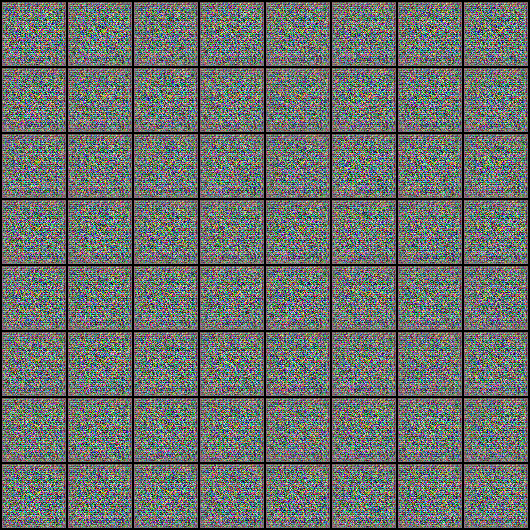

In [31]:
from IPython.display import Image
Image('./generated/generated_image_0400.png')

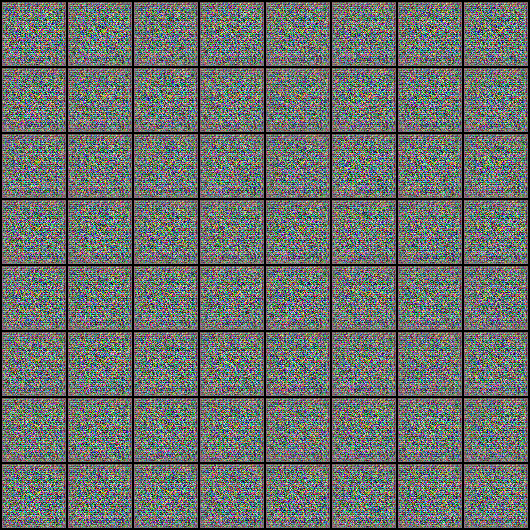

In [32]:
Image('./generated/generated_image_0200.png')

Text(0.5, 1.0, 'Losses')

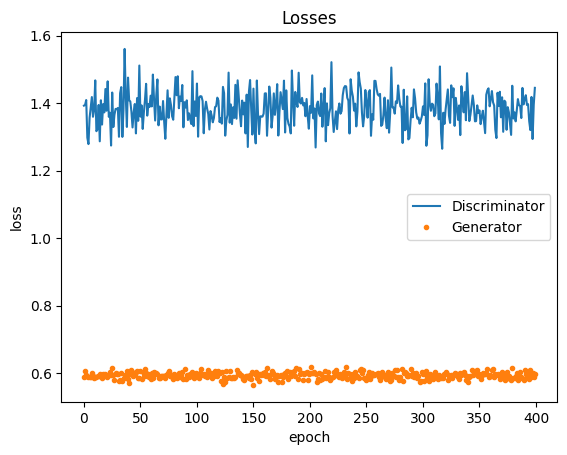

In [33]:
from matplotlib import pyplot as plt
plt.plot(losses_d, '-')
plt.plot(losses_g, '.')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')

Text(0.5, 1.0, 'Losses')

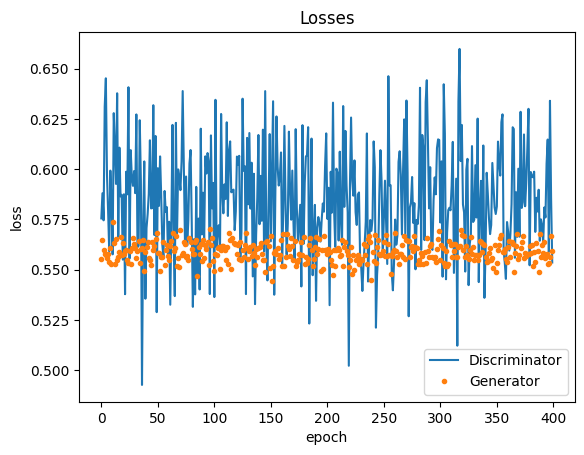

In [34]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '.')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')

In [36]:
import pickle
data_model = [losses_g, losses_d, real_scores, fake_scores]
file_path = 'data_model.pickle'

with open(file_path, 'wb') as file:
    # Serialize and write the variable to the file
    pickle.dump(data_model, file)